Microsoft has created an algorithm called *TrueSkill* for the purpose of ranking players using its video game platform.  It is basically a probabalistic algorithm based on the *Elo* algorithm used to rank chess players.  It can be used to rank players in any activity where there is some concept of win/lose/draw.  The algorithm itself is somewhat hard to understand but fortunately someone has created a Python package which makes it easy to use without understanding the theory behind it. 

First we read in the data files we need.

In [3]:
import pandas as pd 

results = pd.read_csv('./data/Stage2DataFiles/RegularSeasonCompactResults.csv')
tourney = pd.read_csv('./data/Stage2DataFiles/NCAATourneyCompactResults.csv')
seeds = pd.read_csv('./data/Stage2DataFiles/NCAATourneySeeds.csv')
teams = pd.read_csv('./data/Stage2DataFiles/Teams.csv')

Next we define the function which actually uses TrueSkill to rank the teams in a given season.

In [5]:
from trueskill import Rating, rate_1vs1
from collections import defaultdict

def get_ratings(season):         
    # start all teams with a default rating
    ratings = defaultdict(Rating)         
    # get data for season
    current_results = results[results['Season'] == season]                                           
    # at the start, all teams are equal which is not realistic so we loop
    # through the season's games several times to get better starting ratings
    for epoch in range(10):                                 
        # loop through the games in order
        for _, row in current_results.sort_values('DayNum').iterrows():                                                    
            wteamid = row['WTeamID']                                                                 
            lteamid = row['LTeamID']    
            # have TrueSkill compute new ratings based on the game result
            ratings[wteamid], ratings[lteamid] = rate_1vs1(ratings[wteamid], ratings[lteamid])       
    # just keep the mean rating
    return {team_id: rating.mu for team_id, rating in ratings.items()}

The above function is a bit slow, so we'll use multiprocessing to compute ratings for each season in parallel.

In [6]:
from multiprocessing import Pool

p = Pool()    
seasons = results['Season'].unique()
ratings = p.map(get_ratings, seasons)                                                                
p.close()                                                                                            
p.join() 

# put ratings into a dict for easy access
ratings = dict(zip(seasons, ratings))

# lets take a look at 2019 rankings
team_names = dict(zip(teams['TeamID'], teams['TeamName']))
ratings_2019 = [(team_names[t], r) for t, r in ratings[2019].items()]
pd.DataFrame(ratings_2019, columns=['TeamID', 'Rating']).sort_values('Rating', ascending=False)


,TeamID,Rating
58,Virginia,43.571669
104,Duke,42.585001
44,North Carolina,41.289900
249,Tennessee,40.798078
318,Houston,40.511739
...,...,...
149,MS Valley St,10.735895
141,MD E Shore,10.562677
5,Alabama A&M,10.394607
103,Delaware St,9.887045


So now that we have ratings we can try to turn them into probabilities for the 2019 tournament games.  We will do this by using results from past NCAA tournament games with the ratings as features and training a logistic regression model.

In [7]:
train = []                                                                                           
target = []              
# create training data with past tournament results
for _, row in tourney.iterrows():                                                                    
    season = row['Season']                                                                           
    wteamid = row['WTeamID']                                                                         
    lteamid = row['LTeamID']                                                                         
    # we add two rows per game so the target is not all '0' or '1'
    # it might be better to randomly choose winner or loser first
    # or always have higher ratings first
    train.append([ratings[season][wteamid], ratings[season][lteamid]])                               
    target.append(1)                                                                                 
    train.append([ratings[season][lteamid], ratings[season][wteamid]])                               
    target.append(0)     
train = pd.DataFrame(train, columns=['Team1', 'Team2'])
target = pd.Series(target, name='Target')
pd.concat((train, target), axis=1)


,Team1,Team2,Target
0,32.909987,34.899946,1
1,34.899946,32.909987,0
2,33.525544,36.307478,1
3,36.307478,33.525544,0
4,43.912445,18.102306,1
...,...,...,...
4363,32.889824,37.816502,0
4364,41.094739,39.574644,1
4365,39.574644,41.094739,0
4366,41.094739,37.816502,1


OK, now we can train a model to give winning probability given two ratings.

In [8]:
from sklearn.linear_model import LogisticRegression                                                  
from sklearn.preprocessing import StandardScaler 

ss = StandardScaler()                                                                                                                                
train = ss.fit_transform(train)                                                            
lr = LogisticRegression()                                                                            
lr.fit(train, target) 
'intercept: {} coefficients: {}'.format(lr.intercept_[0], lr.coef_[0])

'intercept: 2.5590348869607595e-17 coefficients: [ 0.92658964 -0.92658964]'

Now that we have our model, we can predict winning probabilities for 2019 tournament games.  First we need to build a test set similar to the training set.

In [9]:
# get seeds for 2019 tournament
seeds2019 = seeds['TeamID'][seeds['Season'] == 2019].unique() 
# loop though every possible matchup
predictions = []
for team1 in seeds2019:                                                                                  
    for team2 in seeds2019:                                                                              
        if team1 < team2:
            # we're going to get probabilites for team1 vs team2 and team2 vs team1 and average them
            test_rows = [                                                                            
                [ratings[2019][team1], ratings[2019][team2]],                                        
                [ratings[2019][team2], ratings[2019][team1]],                                        
            ]                                                                                        
            test_rows = ss.transform(test_rows)                                                      
            prob = lr.predict_proba(test_rows)[:, 1]                                                 
            avg_prob = (prob[0] + (1 - prob[1])) / 2     
            predictions.append([team_names[team1], team_names[team2], avg_prob])


Any now we can look at the results.

In [12]:
pd.DataFrame(predictions, columns=['Team1', 'Team2', 'Team1 Win Prob'])

,Team1,Team2,Team1 Win Prob
0,Duke,Michigan St,0.633931
1,Duke,LSU,0.688558
2,Duke,Virginia Tech,0.746982
3,Duke,Mississippi St,0.778497
4,Duke,Maryland,0.782697
...,...,...,...
2273,Gardner Webb,Iowa,0.114425
2274,Gardner Webb,St Mary's CA,0.192911
2275,Gardner Webb,Oregon,0.200820
2276,Gardner Webb,UC Irvine,0.198137


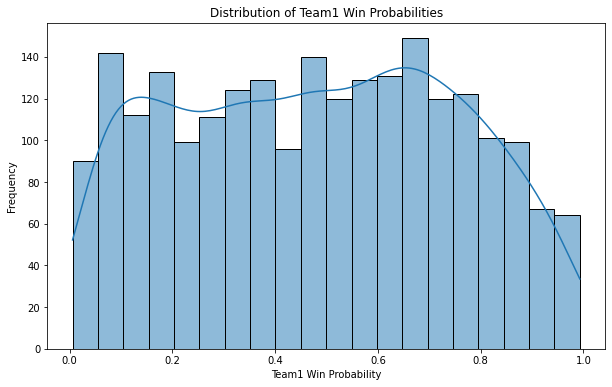

/home/tanishq/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


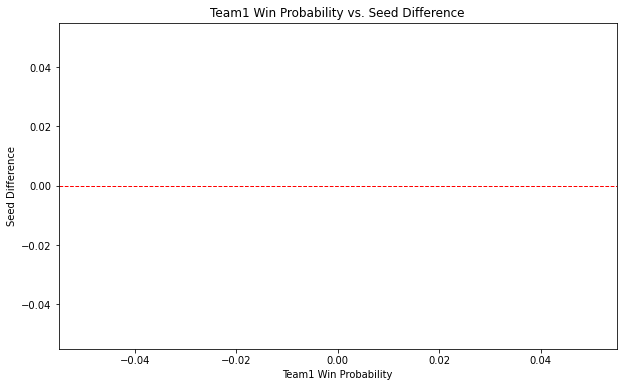

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Team1', 'Team2', 'Team1 Win Prob'])

# Distribution of Team1 Win Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['Team1 Win Prob'], bins=20, kde=True)
plt.title('Distribution of Team1 Win Probabilities')
plt.xlabel('Team1 Win Probability')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of Team1 Win Probabilities vs. Seed Difference
seeds_2019_df = seeds[seeds['Season'] == 2019]
seeds_2019_df['Seed'] = seeds_2019_df['Seed'].str.extract('(\d+)').astype(int)
seeds_2019_df = seeds_2019_df.rename(columns={'TeamID': 'Team1'})
seeds_2019_df['Team1'] = seeds_2019_df['Team1'].astype(str)
predictions_df = predictions_df.merge(seeds_2019_df, on='Team1', how='left')
predictions_df['Team2 Seed'] = predictions_df['Seed']
predictions_df['Seed Difference'] = predictions_df['Seed'] - predictions_df['Team2 Seed']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_df, x='Team1 Win Prob', y='Seed Difference')
plt.title('Team1 Win Probability vs. Seed Difference')
plt.xlabel('Team1 Win Probability')
plt.ylabel('Seed Difference')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)  # Highlighting where the seeds are equal
plt.show()


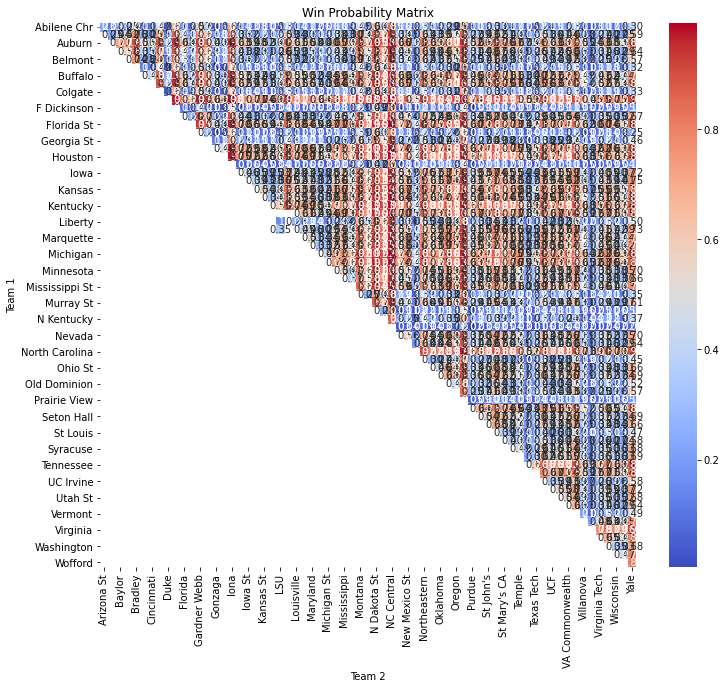

In [16]:
# Pivot predictions_df to create a matrix of win probabilities
win_prob_matrix = predictions_df.pivot(index='Team1', columns='Team2', values='Team1 Win Prob')

# Plot heatmap of win probabilities
plt.figure(figsize=(12, 10))
sns.heatmap(win_prob_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Win Probability Matrix')
plt.xlabel('Team 2')
plt.ylabel('Team 1')
plt.show()

